In [18]:
import pandas as pd
import matplotlib as plt 
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 

In [19]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [20]:
def transform_features(df, drop_cutoff):
    data = df.copy()
    
    n_dropped_col = len(data.columns)
    
    # Remove time related data to avoid data leakage
    time_features = ["Yr Sold","Year Built", "Year Remod/Add", "Garage Yr Blt"]
    data = data.drop(time_features, axis=1)
    
    # Drop column that contains more than cutoff% of Nan values
    null_count = data.isnull().sum()
    column_to_remove = null_count[null_count > (drop_cutoff/100)*data.shape[0]].index.tolist()
    data = data.drop(column_to_remove, axis=1)
    
    
    
    print("{}/{} columns removed during tranformation".format( n_dropped_col - len(data.columns), n_dropped_col))
    
    return data
    
def select_features(df):
    features = ["Gr Liv Area","SalePrice"]
    return df[features]

def train_and_test(data):
    train = data.iloc[:1460]
    test = data.iloc[1460:]
    
    numerical_train = train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    numerical_test = test.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    
    features = numerical_train.columns.drop(["SalePrice"])
    print(features)
    
    lr = LinearRegression()
    lr.fit(numerical_train[features], numerical_train["SalePrice"])
    prediction = lr.predict(numerical_test[features])
    rmse = mean_squared_error(prediction, numerical_test["SalePrice"])**0.5
    return rmse

In [28]:
tdf = transform_features(df, 20)
#tdf.info()

9/82 columns removed during tranformation


In [50]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerical_df = df.select_dtypes(include=numerics)
null_count = numerical_df.isnull().sum()
num_2_replace = null_count[ null_count < (5/100)*numerical_df.shape[0] ].index

numerical_df[num_2_replace] = numerical_df[num_2_replace].fillna(numerical_df[num_2_replace].mean())
null_count = numerical_df.isnull().sum()
print(null_count)

Order                0
PID                  0
MS SubClass          0
Lot Frontage       490
Lot Area             0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Mas Vnr Area         0
BsmtFin SF 1         0
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Bsmt Full Bath       0
Bsmt Half Bath       0
Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
TotRms AbvGrd        0
Fireplaces           0
Garage Yr Blt      159
Garage Cars          0
Garage Area          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Mo Sold              0
Yr Sold              0
SalePrice            0
dtype: int64


In [52]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    ## You can use `pd.DataFrame.select_dtypes()` to specify column types
    ## and return only those columns as a data frame.
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    ## You can use `pd.Series.drop()` to drop a value.
    features = numeric_train.columns.drop("SalePrice")
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.367312413066

## Feature selection

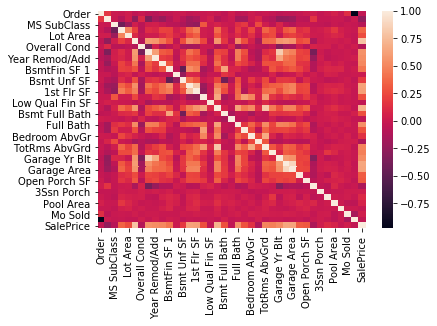

In [66]:
import seaborn as sns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_df = df.select_dtypes(include=numerics)

sns.heatmap(numerical_df.corr())

In [71]:
from sklearn.model_selection import KFold

def transform_features(df):
    # Removing columns with missing value (over 20%)
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    # Drop any string columns with a null value
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    # Replacing missing value with mode for numerical with less than 20% missing value
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    # Keeping columns with correlation to salePrice greater than the threshold
    numerical_df = df.select_dtypes(include=['integer', 'float'])
    abs_corr_coeffs = numerical_df.corr()["SalePrice"].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    # Handling categorical data
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    features = numeric_df.columns.drop("SalePrice")
    lr = LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[40769.91401621256, 28697.406904678486, 32391.588219320758, 30599.42396199674]


33114.58327555213

Pour aller plus loin : https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python